In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-preprocessed-bitri/data_preprocessed_bitri.csv
/kaggle/input/wcr-w2v-model/wcr_trigrams_300features_5minwords_20context (2).bin


# Women's Clothing Reviews - Sentiment Analysis: Model Building

## Overall Project Goal
In this project I want to understand this dataset on women's clothing reviews, create a Word2Vec model based off of the review texts in the data set and then use this Word2Vec model to build a sentiment analysis model on the dataset which attempts to predict whether the customer left a 5-star review or not.

### Project Notebooks
This notebook is part of a series of 3 notebooks on performing sentiment analysis on a dataset of women's clothing reviews.
1. Women's Clothing Reviews - Sentiment Analysis: EDA **{ADD LINKS}**
2. Women's Clothing Reviews - Sentiment Analysis: Building Word2Vec Model
3. **Women's Clothing Reviews - Sentiment Analysis: Building a Sentiment Analysis Model**



## Goal of this notebook: Building Word2Vec Model
In this notebook I want to: vectorise the data, split it into test, train and validation sets and build our sentiment analysis model using an LSTM architecture to attempt to classify whether a customer left a 5-star review or not, using their review text.

## 1. Loading Libraries and Data

In [2]:
# Data manipulation tools
import numpy as np
import pandas as pd

# Data visualisation tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Tools for building a LSTM model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import tensorflow as tf

# Evaluating model performance
from sklearn.metrics import accuracy_score

# To load the pretrained word2vec model
from gensim.models import Word2Vec, Phrases

In [3]:
# Loading the cleaned and preprocessed dataset
data = pd.read_csv('/kaggle/input/data-preprocessed-bitri/data_preprocessed_bitri.csv', usecols=['Five Star', 'Total Text'])

In [4]:
# Looking at the first 5 rows of the data
data.head()

,Five Star,Total Text
0,0,"['absolutely', 'wonderful', 'silky', 'sexy', '..."
1,1,"['love', 'dress', 'sooo', 'pretty', 'happen', ..."
2,0,"['major', 'design_flaw', 'high_hop', 'dress', ..."
3,1,"['favorite', 'buy', 'love', 'love', 'love', 'j..."
4,1,"['flatter', 'shirt', 'shirt', 'flatter', 'due'..."


Now we are left with a dataframe that only contains two columns. The `Five Star` column, which is the target variable and the `Total Text` column, which is a concatenation of the title and the main text of the review. The `Total Text` column has also been preprocessed: it has had html removed, non letters removed, been made lowercase, stopwords removed and lemmatized. It has then be formatted to be a list of lists.

## 2. Vectorising Data

In [5]:
# Finding the longest review to use number in padding later
longest_review = max([len(review.split()) for review in data['Total Text']])
print(f'The longest text used in the model has a length {longest_review}')

The longest text used in the model has a length 60


In [6]:
from gensim.models import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format('/kaggle/input/wcr-w2v-model/wcr_trigrams_300features_5minwords_20context (2).bin', binary=True)

In [7]:
%%time
def vectorize_data(X_data, vocab):
    
    # This function takes in text data in the format of a review being broken down into a list 
    # of tokens, and a our vocab dictionary from the word2vec model we previously trained. It
    # outputs the reviews broken down into a list indexes which refer to the vectors trained by the w2v model
    
    
    print('Vectorizing sentences...')
    
    # Get the keys from the vocab dictionary
    keys = list(vocab.keys())
    
    # Define a function to check if a word is in the vocab
    def is_known(word):
        return word in keys
    
    # Define a function to encode a review by mapping each word to its index in the vocab
    def encode_review(review):
        return [keys.index(word) for word in review if is_known(word)]
    
    # Vectorize each review in the data using the encode_review function
    vectorized_data = [encode_review(review) for review in X_data]
    
    print('Vectorizing sentences... Done')
    return vectorized_data


# This is padding the reviews so that they all have the same length
input_length = longest_review
X_pad = pad_sequences(
    sequences=vectorize_data(data['Total Text'], vocab=w2v_model.key_to_index),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Vectorizing sentences...
Vectorizing sentences... Done
Transform sentences to sequences... (done)
CPU times: user 6min 57s, sys: 198 ms, total: 6min 57s
Wall time: 6min 57s


## 3. Splitting Data into Train, Test and Validation Sets

In [8]:
# Splitting the target variable and the text
X_data = X_pad
y_data = data['Five Star']

In [9]:
# Splitting the data into train, test and validation sets
from sklearn.model_selection import train_test_split

# Split data into train and test sets (70% for training and 30% for testing)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

# Split the test set into test and validation sets (50% each)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Training set length: ", len(X_train))
print("Validation set length: ", len(X_val))
print("Test set length: ", len(X_test))

Training set length:  15848
Validation set length:  3397
Test set length:  3396


## 4. Building LSTM Sentiment Analysis Model

In [10]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Instantiate the model
def build_model(embedding_matrix: np.ndarray, input_length: int, random_seed: int = 42):
    tf.random.set_seed(random_seed)
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

# Build the model using the w2v vectors
model = build_model(
    embedding_matrix=w2v_model.vectors,
    input_length=input_length,
    random_seed=42)

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

# Add early stop to stop training if val loss stops changing
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Fit the model to the data
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=100,
    epochs=30, 
    callbacks=[early_stop])

# Saving the trainined model
model.save('LSTM_model_30epochs.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 300)           1587300   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

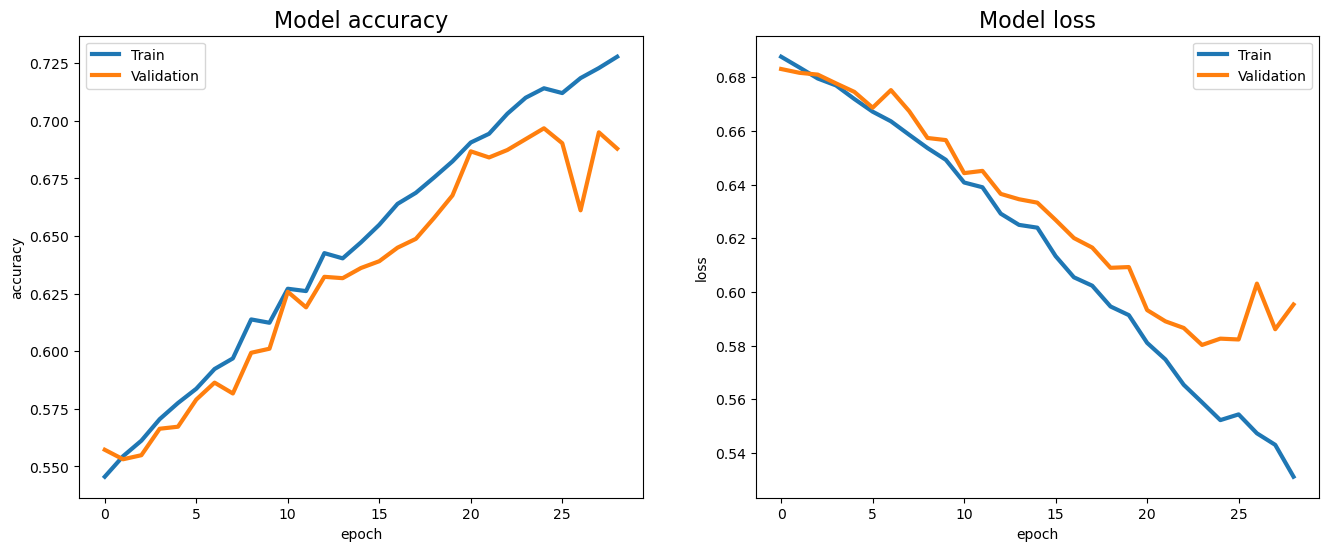

In [11]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [12]:
# Make predictions on the test data
y_test_preds = model.predict(X_test)
y_test_preds = (y_test_preds > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, y_test_preds)

print(f'The accuracy score on the test set is {test_accuracy:.3f}')

107/107 [==============================] - 4s 33ms/step
The accuracy score on the test set is 0.691


In [13]:
y_test.index

Int64Index([10936, 14320, 22062,  9298, 21681,  3187, 15808,  1704,  6692,
             6377,
            ...
               49,  8692, 16699,  3410,  2893, 15446, 11960, 14197, 16882,
            14811],
           dtype='int64', length=3396)

# Todo
- Add a section looking at the predictions against the reality.
    - I want to see how well the model performed on different ratings (need to find a way to make a df that has all ratings again not just 5 star or not)
- Add a conclusion section that summarises what I have done in the project and summarises the results
- Talk about how good the result was and investigate the quality of the data
    - For example see if it is very hard to predict whether a review was 4 or 5 star because the text is very positive etc.
        - Discuss what this could be due to and how it limits the predictability of the model
       